In [1]:
from __future__ import division
import math
import numpy as np
import collections
from scipy import optimize as opt
import matplotlib.pyplot as plt

In [84]:
class Dirichilet_Hawkes_Process(object):
    def __init__(self, mu0, reference_time, theta0, alpha0):
        self.docs = None
        self.topics = None
        self.reference_time = reference_time
        self.mu0 = mu0
        self.theta0 = theta0
        self.alpha0 = alpha0
        
    def generative_process(self):
        print("-------------------------------------------------")
        print("-------------------------------------------------")
        print("-----------Generative process begins-------------")
        print("-------------------------------------------------")
        print("-------------------------------------------------")
        self.docs = []
        rates = []
        
        t1 = self.homo_possion_time_sampler(self.mu0)
        theta1 = self.dirichlet_distribution_sampler(self.theta0)
        alpha1 = self.dirichlet_distribution_sampler(self.alpha0)
        doc1 = {"time": t1, "topic": None, "theta": theta1, "alpha": alpha1}
        self.docs.append(doc1)
        tmax = 100000
        
        while(len(self.docs) <= 500 and self.docs[-1]['time'] <= (tmax)):
            
            thetas2rates = {'theta0' : self.mu0} # local variable, record the rate of distinctive theta
            index2thetas = {0: 'theta0'} # local variable, record the index of distinctive theta
            
            current_rate_function = lambda t: self.rate_function(t, self.docs, mu0 = self.mu0,\
                                                                 reference_time = self.reference_time)

            tn, ratio, mu_sup = self.nonhomo_poisson_time_sampler(current_rate_function, self.docs[-1]["time"],\
                                                          len(self.docs), tmax)
            print('ratio = %.3f, mu_sup = %.3f' % (ratio, mu_sup))
            #print(self.rate_function(tn, self.docs, mu0 = self.mu0, reference_time = self.reference_time))   
            #print(self.mu0)
            #print(self.triggering_kernel(self.docs[0]['alpha'], self.reference_time, tn, self.docs[0]['time']))

            # draw theta of the current document
            for doc in self.docs:
                if tuple(doc['theta']) not in thetas2rates:
                    thetas2rates[tuple(doc['theta'])] = self.triggering_kernel(doc['alpha'],\
                                                                              self.reference_time, tn, doc['time'])
                    index2thetas[len(index2thetas)] = tuple(doc['theta'])
                else:
                    thetas2rates[tuple(doc['theta'])] += self.triggering_kernel(doc['alpha'],\
                                                                                self.reference_time, tn, doc['time'])                                                   
                 
            
            '''
            current_rate = self.rate_function(tn, self.docs, mu0 = self.mu0, reference_time = self.reference_time)
            print(current_rate)
            theta_probabilities = [self.mu0/current_rate]
            for doc in self.docs:
                rate = self.triggering_kernel(doc['alpha'], self.reference_time, tn, doc['time'])
                theta_probabilities.append(rate / current_rate)
            
            print(theta_probabilities)
            theta_index = self.multinomial_distribution_sampler(1, theta_probabilities)
            theta_index = np.flatnonzero(theta_index)[0]
            '''
            current_rate = self.rate_function(tn, self.docs, mu0 = self.mu0, reference_time = self.reference_time)
            rates.append(current_rate)
            print("current rate is %.5f" %current_rate) 
            theta_probabilities = []
            
            for theta, rate in thetas2rates.iteritems():
                theta_probabilities.append(rate/current_rate)
            
            #print(theta_probabilities)   
            theta_index = self.multinomial_distribution_sampler(1, theta_probabilities)
            theta_index = np.flatnonzero(theta_index)[0]
        
            if theta_index != 0:
                theta_n = np.asarray(index2thetas[theta_index])
            else:
                theta_n = self.dirichlet_distribution_sampler(self.theta0)

            alpha_n = self.dirichlet_distribution_sampler(self.alpha0)    
            docn = {"time": tn, "topic": None, "theta": theta_n, "alpha": alpha_n}
            self.docs.append(docn)
            print("the number of documents is %d" %len(self.docs))
            
        return rates
            
    def homo_possion_time_sampler(self, mu0):
        ''' Return a random time point given a constant rate mu0.
        
        Attributes: 
            mu0: constant rate
        '''
        return -math.log(1.0 - np.random.rand()) / mu0
    
    def dirichlet_distribution_sampler(self, alpha0 = [1] * 10):
        ''' Draw samples from a dirichlet distribution. Return a multinomial probability distribution.
        
        Attributes:
            alpha0: Parameter of the distribution (k dimension for sample of dimension k).
        '''
        return np.random.dirichlet(alpha0).squeeze()
    
    def multinomial_distribution_sampler(self, word_count, probabilities):
        ''' Draw samples from a multinomial distribution.
        
        Attributes:
            word_count: Number of experiments, in our case, the word count of one document.
            probabilities: multinomial probability distribution (sequence of floats).
        '''
        
        return np.random.multinomial(word_count, probabilities).squeeze()
    
    def RBF_kernel(self, reference_time, time_interval, bandwidth = 0.5):
        ''' RBF kernel for Hawkes process.
        
        Attributes: 
            reference_time: float, larger than 0.
            time_interval: float, larger than 0.
            bandwidth: bandwidth for RBF.
        '''
        numerator = - (time_interval - reference_time) ** 2 / (2 * bandwidth ** 2) 
        denominator = (2 * np.pi * bandwidth ** 2 ) ** 0.5
        return np.exp(numerator) / denominator
    
    def triggering_kernel(self, alpha, reference_time, ti, tj):
        ''' triggering kernel for Hawkes prcess.
            
        Attributes:
            alpha: sequence of float, weight for different kernels.
            kernel: function name, kernel function for the triggering kernel.
            reference_time: sequence of float, reference time for different kernels. 
        '''
        if len(alpha) != len(reference_time):
            raise Exception("length of alpha and length of reference time must equal")
        kernels = []
        for l in range(len(alpha)):
            kernels.append(self.RBF_kernel(reference_time[l], ti - tj))
            
        return np.sum(np.array(alpha) * np.array(kernels))
    
    def nonhomo_poisson_time_sampler(self, rate_func, last_doc_time, number_of_doc, tmax):
        ''' From Algorithm 6 in 'Generating Nonhomogeneous Poisson Processes'
            see http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=2BE0E5EE6F19D5C8B461C3703DC9B1DD?doi=10.1.1.418.5187&rep=rep1&type=pdf
            
        Attributes:
            last_doc_time:  t_{n-1} when document n-1 arrives
            rate_func: rate function, cannnot less than zero
            number_of_doc:
        '''
        t = last_doc_time
        intervel = t / number_of_doc

        t_opt = opt.fminbound(lambda x: -rate_func(x), 0, tmax, disp= 0)
        mu_sup = rate_func(t_opt)
        #t_opt = opt.fmin(lambda x: -rate_func(x),t/2, disp= False)
        
        u1 = np.random.rand() 
        t = t - np.log(u1) / mu_sup
        u2 = np.random.rand()

        if u2 <= (rate_func(t) / mu_sup):
            return t, (rate_func(t) / mu_sup), mu_sup
        else:
            return self.nonhomo_poisson_time_sampler(rate_func, last_doc_time, number_of_doc, tmax)

    def rate_function(self, t, docs = [], mu0 = 1, reference_time = [7, 11]):
        ''' the rate function of DHP for generate continuous-time document sequence.
        
        Attributes: 
            t: current time 
            docs: the document sequence by now
            mu0: base intensity
            reference_time: reference time for triggering kernel
        '''
        rate = mu0
        for doc in docs:
            rate = rate + self.triggering_kernel(doc['alpha'], reference_time, t, doc['time'])
        return rate

In [85]:
DHP = Dirichilet_Hawkes_Process(mu0 = 0.01, reference_time = [7, 11], theta0 = [1]*4, alpha0 = [1]*2)
print(DHP.mu0)
print(DHP.reference_time)
print(len(DHP.theta0))
print(len(DHP.alpha0))

0.01
[7, 11]
4
2


In [86]:
rates = DHP.generative_process()

-------------------------------------------------
-------------------------------------------------
-----------Generative process begins-------------
-------------------------------------------------
-------------------------------------------------
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 2
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 3
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 4
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 5
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 6
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 7
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 8
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 9
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 10
ra

ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 99
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 100
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 101
ratio = 5.317, mu_sup = 0.010
current rate is 0.05317
the number of documents is 102
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 103
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 104
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 105
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 106
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 107
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 108
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 109
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number o

ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 196
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 197
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 198
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 199
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 200
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 201
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 202
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 203
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 204
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 205
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 206
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number 

ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 293
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 294
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 295
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 296
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 297
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 298
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 299
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 300
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 301
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 302
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 303
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number 

the number of documents is 390
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 391
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 392
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 393
ratio = 1.624, mu_sup = 0.010
current rate is 0.01624
the number of documents is 394
ratio = 1.223, mu_sup = 0.010
current rate is 0.01223
the number of documents is 395
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 396
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 397
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 398
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 399
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 400
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 401
ratio = 1.000, mu_sup = 0.010
curr

ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 487
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 488
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 489
ratio = 15.846, mu_sup = 0.010
current rate is 0.15846
the number of documents is 490
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 491
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 492
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 493
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 494
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 495
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 496
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number of documents is 497
ratio = 1.000, mu_sup = 0.010
current rate is 0.01000
the number

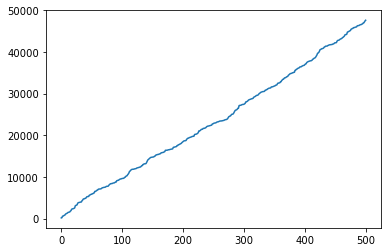

In [87]:
x = np.arange(0,len(DHP.docs))
arrival_times = []
for i in xrange(len(DHP.docs)):
    arrival_times.append(DHP.docs[i]['time'])
y = np.array(arrival_times)

plt.plot(x,y)
plt.show()

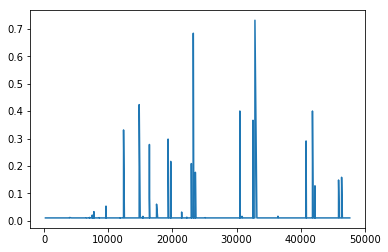

In [88]:
x = np.array(arrival_times[1:])
y = np.array(rates)

plt.plot(x,y)
plt.show()

In [79]:
for doc in DHP.docs:
    print(doc)

{'topic': None, 'theta': array([ 0.22707295,  0.0465594 ,  0.24356545,  0.48280219]), 'alpha': array([ 0.82629549,  0.17370451]), 'time': 191.46486596001753}
{'topic': None, 'theta': array([ 0.22707295,  0.0465594 ,  0.24356545,  0.48280219]), 'alpha': array([ 0.1069475,  0.8930525]), 'time': 203.44922773102078}
{'topic': None, 'theta': array([ 0.27921369,  0.2778069 ,  0.21023725,  0.23274215]), 'alpha': array([ 0.83339133,  0.16660867]), 'time': 358.52469353139293}
{'topic': None, 'theta': array([ 0.10322553,  0.14608052,  0.16321619,  0.58747776]), 'alpha': array([ 0.73688328,  0.26311672]), 'time': 630.46825079181531}
{'topic': None, 'theta': array([ 0.17320247,  0.47513275,  0.09120477,  0.26046002]), 'alpha': array([ 0.07071304,  0.92928696]), 'time': 760.82678859845987}
{'topic': None, 'theta': array([ 0.50730881,  0.19773294,  0.22031   ,  0.07464825]), 'alpha': array([ 0.44452224,  0.55547776]), 'time': 853.57660445920965}
{'topic': None, 'theta': array([ 0.19628975,  0.561766

{'topic': None, 'theta': array([ 0.72599433,  0.0826302 ,  0.07881185,  0.11256363]), 'alpha': array([ 0.26097132,  0.73902868]), 'time': 50738.01944159525}
{'topic': None, 'theta': array([ 0.22707295,  0.0465594 ,  0.24356545,  0.48280219]), 'alpha': array([ 0.25999109,  0.74000891]), 'time': 50932.6851188773}
{'topic': None, 'theta': array([ 0.22707295,  0.0465594 ,  0.24356545,  0.48280219]), 'alpha': array([ 0.33171904,  0.66828096]), 'time': 51012.266405371935}
{'topic': None, 'theta': array([ 0.22707295,  0.0465594 ,  0.24356545,  0.48280219]), 'alpha': array([ 0.29225594,  0.70774406]), 'time': 51264.114894885708}
{'topic': None, 'theta': array([ 0.22707295,  0.0465594 ,  0.24356545,  0.48280219]), 'alpha': array([ 0.90008412,  0.09991588]), 'time': 51317.209855778674}
{'topic': None, 'theta': array([ 0.22707295,  0.0465594 ,  0.24356545,  0.48280219]), 'alpha': array([ 0.25813689,  0.74186311]), 'time': 51449.042942907196}
{'topic': None, 'theta': array([ 0.22707295,  0.0465594

In [24]:
import scipy.optimize as opt
import scipy
import numpy as np
def f(x):
    #print x
    return 2*x

max_x = opt.fminbound(lambda x: -f(x), 0, 9 , disp=0)
print(max_x)

8.99999563972


In [59]:
max([1,2,3])

3